# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

Gradients are different at (0,). Analytic: 1.00000, Numeric: 0.50000


# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [9]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [10]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [11]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, np.array([1]))

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [12]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), np.array([1]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [13]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [14]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [15]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [16]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 0.219017
Epoch 1, loss: 0.065851
Epoch 2, loss: 0.020561
Epoch 3, loss: 0.007310
Epoch 4, loss: 0.003426
Epoch 5, loss: 0.002230
Epoch 6, loss: 0.001933
Epoch 7, loss: 0.001859
Epoch 8, loss: 0.001776
Epoch 9, loss: 0.001811


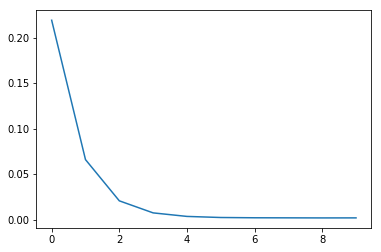

In [17]:
# let's look at the loss history!
plt.plot(loss_history)

In [26]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.167
Epoch 0, loss: 0.001744
Epoch 1, loss: 0.001800
Epoch 2, loss: 0.001794
Epoch 3, loss: 0.001834
Epoch 4, loss: 0.001807
Epoch 5, loss: 0.001812
Epoch 6, loss: 0.001819
Epoch 7, loss: 0.001843
Epoch 8, loss: 0.001850
Epoch 9, loss: 0.001760
Epoch 10, loss: 0.001785
Epoch 11, loss: 0.001830
Epoch 12, loss: 0.001801
Epoch 13, loss: 0.001770
Epoch 14, loss: 0.001813
Epoch 15, loss: 0.001817
Epoch 16, loss: 0.001864
Epoch 17, loss: 0.001815
Epoch 18, loss: 0.001844
Epoch 19, loss: 0.001793
Epoch 20, loss: 0.001800
Epoch 21, loss: 0.001791
Epoch 22, loss: 0.001770
Epoch 23, loss: 0.001863
Epoch 24, loss: 0.001765
Epoch 25, loss: 0.001816
Epoch 26, loss: 0.001749
Epoch 27, loss: 0.001772
Epoch 28, loss: 0.001826
Epoch 29, loss: 0.001841
Epoch 30, loss: 0.001817
Epoch 31, loss: 0.001801
Epoch 32, loss: 0.001836
Epoch 33, loss: 0.001775
Epoch 34, loss: 0.001797
Epoch 35, loss: 0.001800
Epoch 36, loss: 0.001799
Epoch 37, loss: 0.001794
Epoch 38, loss: 0.001814
Epoch 39, loss: 0.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [27]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
reg_strengths = [1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = -1.0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
num_samples = train_y.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)

split_index = num_samples * 2 // 10
train_indices = indices[split_index:]
val_indices = indices[:split_index]

cv_train_X = train_X[train_indices]
cv_train_y = train_y[train_indices]

val_X = train_X[val_indices]
val_y = train_y[val_indices]

for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        print(f'learning_rate = {learning_rate}, reg_strength = {reg_strength}')
        clsr = linear_classifer.LinearSoftmaxClassifier()
        clsr.fit(cv_train_X, cv_train_y, epochs=100, learning_rate=learning_rate, batch_size=300, reg=reg_strength)
        clsr_pred = clsr.predict(val_X)
        accuracy = multiclass_accuracy(clsr_pred, val_y)
        print(f'accuracy = {accuracy}')
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = clsr

print('best validation accuracy achieved: %f' % best_val_accuracy)
assert best_val_accuracy > 0.20

learning_rate = 0.01, reg_strength = 10.0
Epoch 0, loss: 0.002703
Epoch 1, loss: 0.003998
Epoch 2, loss: 0.004226
Epoch 3, loss: 0.003936
Epoch 4, loss: 0.003484
Epoch 5, loss: 0.003230
Epoch 6, loss: 0.002936
Epoch 7, loss: 0.003428
Epoch 8, loss: 0.003030
Epoch 9, loss: 0.004600
Epoch 10, loss: 0.003168
Epoch 11, loss: 0.003635
Epoch 12, loss: 0.004070
Epoch 13, loss: 0.003192
Epoch 14, loss: 0.002876
Epoch 15, loss: 0.003066
Epoch 16, loss: 0.003240
Epoch 17, loss: 0.003202
Epoch 18, loss: 0.003224
Epoch 19, loss: 0.003713
Epoch 20, loss: 0.003394
Epoch 21, loss: 0.003276
Epoch 22, loss: 0.003196
Epoch 23, loss: 0.002239
Epoch 24, loss: 0.004053
Epoch 25, loss: 0.003286
Epoch 26, loss: 0.003287
Epoch 27, loss: 0.004069
Epoch 28, loss: 0.003077
Epoch 29, loss: 0.003833
Epoch 30, loss: 0.003838
Epoch 31, loss: 0.002866
Epoch 32, loss: 0.003249
Epoch 33, loss: 0.003134
Epoch 34, loss: 0.003766
Epoch 35, loss: 0.003227
Epoch 36, loss: 0.003037
Epoch 37, loss: 0.003338
Epoch 38, loss: 0.

Epoch 20, loss: 0.008898
Epoch 21, loss: 0.009474
Epoch 22, loss: 0.010000
Epoch 23, loss: 0.010635
Epoch 24, loss: 0.011206
Epoch 25, loss: 0.011698
Epoch 26, loss: 0.012521
Epoch 27, loss: 0.012893
Epoch 28, loss: 0.013681
Epoch 29, loss: 0.014079
Epoch 30, loss: 0.014604
Epoch 31, loss: 0.015493
Epoch 32, loss: 0.015953
Epoch 33, loss: 0.016316
Epoch 34, loss: 0.017158
Epoch 35, loss: 0.017404
Epoch 36, loss: 0.018359
Epoch 37, loss: 0.018693
Epoch 38, loss: 0.019271
Epoch 39, loss: 0.019901
Epoch 40, loss: 0.020375
Epoch 41, loss: 0.020917
Epoch 42, loss: 0.021474
Epoch 43, loss: 0.022074
Epoch 44, loss: 0.022619
Epoch 45, loss: 0.022895
Epoch 46, loss: 0.023666
Epoch 47, loss: 0.023677
Epoch 48, loss: 0.024669
Epoch 49, loss: 0.025128
Epoch 50, loss: 0.025759
Epoch 51, loss: 0.026161
Epoch 52, loss: 0.026177
Epoch 53, loss: 0.026811
Epoch 54, loss: 0.027449
Epoch 55, loss: 0.028232
Epoch 56, loss: 0.028418
Epoch 57, loss: 0.028789
Epoch 58, loss: 0.029650
Epoch 59, loss: 0.030485


Epoch 40, loss: 0.000024
Epoch 41, loss: 0.000025
Epoch 42, loss: 0.000025
Epoch 43, loss: 0.000026
Epoch 44, loss: 0.000027
Epoch 45, loss: 0.000027
Epoch 46, loss: 0.000029
Epoch 47, loss: 0.000029
Epoch 48, loss: 0.000029
Epoch 49, loss: 0.000030
Epoch 50, loss: 0.000031
Epoch 51, loss: 0.000032
Epoch 52, loss: 0.000032
Epoch 53, loss: 0.000033
Epoch 54, loss: 0.000034
Epoch 55, loss: 0.000035
Epoch 56, loss: 0.000035
Epoch 57, loss: 0.000036
Epoch 58, loss: 0.000037
Epoch 59, loss: 0.000038
Epoch 60, loss: 0.000038
Epoch 61, loss: 0.000040
Epoch 62, loss: 0.000040
Epoch 63, loss: 0.000041
Epoch 64, loss: 0.000041
Epoch 65, loss: 0.000042
Epoch 66, loss: 0.000041
Epoch 67, loss: 0.000044
Epoch 68, loss: 0.000044
Epoch 69, loss: 0.000044
Epoch 70, loss: 0.000045
Epoch 71, loss: 0.000046
Epoch 72, loss: 0.000045
Epoch 73, loss: 0.000047
Epoch 74, loss: 0.000048
Epoch 75, loss: 0.000048
Epoch 76, loss: 0.000049
Epoch 77, loss: 0.000049
Epoch 78, loss: 0.000050
Epoch 79, loss: 0.000052


Epoch 61, loss: 0.014112
Epoch 62, loss: 0.014096
Epoch 63, loss: 0.014189
Epoch 64, loss: 0.014187
Epoch 65, loss: 0.014258
Epoch 66, loss: 0.014281
Epoch 67, loss: 0.014269
Epoch 68, loss: 0.014405
Epoch 69, loss: 0.014367
Epoch 70, loss: 0.014491
Epoch 71, loss: 0.014356
Epoch 72, loss: 0.014434
Epoch 73, loss: 0.014512
Epoch 74, loss: 0.014474
Epoch 75, loss: 0.014549
Epoch 76, loss: 0.014559
Epoch 77, loss: 0.014627
Epoch 78, loss: 0.014619
Epoch 79, loss: 0.014657
Epoch 80, loss: 0.014625
Epoch 81, loss: 0.014697
Epoch 82, loss: 0.014655
Epoch 83, loss: 0.014734
Epoch 84, loss: 0.014688
Epoch 85, loss: 0.014754
Epoch 86, loss: 0.014785
Epoch 87, loss: 0.014753
Epoch 88, loss: 0.014792
Epoch 89, loss: 0.014821
Epoch 90, loss: 0.014806
Epoch 91, loss: 0.014884
Epoch 92, loss: 0.014817
Epoch 93, loss: 0.014858
Epoch 94, loss: 0.014813
Epoch 95, loss: 0.014839
Epoch 96, loss: 0.014925
Epoch 97, loss: 0.014904
Epoch 98, loss: 0.014984
Epoch 99, loss: 0.014917
accuracy = 0.159444444444

Epoch 82, loss: 0.000267
Epoch 83, loss: 0.000272
Epoch 84, loss: 0.000277
Epoch 85, loss: 0.000280
Epoch 86, loss: 0.000287
Epoch 87, loss: 0.000290
Epoch 88, loss: 0.000293
Epoch 89, loss: 0.000299
Epoch 90, loss: 0.000302
Epoch 91, loss: 0.000307
Epoch 92, loss: 0.000312
Epoch 93, loss: 0.000316
Epoch 94, loss: 0.000319
Epoch 95, loss: 0.000323
Epoch 96, loss: 0.000329
Epoch 97, loss: 0.000332
Epoch 98, loss: 0.000339
Epoch 99, loss: 0.000342
accuracy = 0.185
learning_rate = 0.001, reg_strength = 0.0001
Epoch 0, loss: 0.000007
Epoch 1, loss: 0.000007
Epoch 2, loss: 0.000007
Epoch 3, loss: 0.000007
Epoch 4, loss: 0.000007
Epoch 5, loss: 0.000007
Epoch 6, loss: 0.000007
Epoch 7, loss: 0.000007
Epoch 8, loss: 0.000007
Epoch 9, loss: 0.000008
Epoch 10, loss: 0.000008
Epoch 11, loss: 0.000008
Epoch 12, loss: 0.000008
Epoch 13, loss: 0.000008
Epoch 14, loss: 0.000008
Epoch 15, loss: 0.000008
Epoch 16, loss: 0.000008
Epoch 17, loss: 0.000008
Epoch 18, loss: 0.000008
Epoch 19, loss: 0.00000

Epoch 0, loss: 0.640755
Epoch 1, loss: 0.582189
Epoch 2, loss: 0.528841
Epoch 3, loss: 0.480371
Epoch 4, loss: 0.436269
Epoch 5, loss: 0.396312
Epoch 6, loss: 0.360044
Epoch 7, loss: 0.327080
Epoch 8, loss: 0.297229
Epoch 9, loss: 0.270063
Epoch 10, loss: 0.245311
Epoch 11, loss: 0.222974
Epoch 12, loss: 0.202624
Epoch 13, loss: 0.184143
Epoch 14, loss: 0.167307
Epoch 15, loss: 0.152094
Epoch 16, loss: 0.138251
Epoch 17, loss: 0.125706
Epoch 18, loss: 0.114313
Epoch 19, loss: 0.103906
Epoch 20, loss: 0.094513
Epoch 21, loss: 0.085921
Epoch 22, loss: 0.078182
Epoch 23, loss: 0.071103
Epoch 24, loss: 0.064760
Epoch 25, loss: 0.058956
Epoch 26, loss: 0.053703
Epoch 27, loss: 0.048905
Epoch 28, loss: 0.044564
Epoch 29, loss: 0.040629
Epoch 30, loss: 0.037040
Epoch 31, loss: 0.033775
Epoch 32, loss: 0.030871
Epoch 33, loss: 0.028180
Epoch 34, loss: 0.025762
Epoch 35, loss: 0.023544
Epoch 36, loss: 0.021542
Epoch 37, loss: 0.019721
Epoch 38, loss: 0.018071
Epoch 39, loss: 0.016577
Epoch 40, 

Epoch 22, loss: 0.000707
Epoch 23, loss: 0.000707
Epoch 24, loss: 0.000708
Epoch 25, loss: 0.000708
Epoch 26, loss: 0.000708
Epoch 27, loss: 0.000708
Epoch 28, loss: 0.000708
Epoch 29, loss: 0.000708
Epoch 30, loss: 0.000709
Epoch 31, loss: 0.000709
Epoch 32, loss: 0.000709
Epoch 33, loss: 0.000710
Epoch 34, loss: 0.000709
Epoch 35, loss: 0.000710
Epoch 36, loss: 0.000710
Epoch 37, loss: 0.000710
Epoch 38, loss: 0.000710
Epoch 39, loss: 0.000710
Epoch 40, loss: 0.000711
Epoch 41, loss: 0.000711
Epoch 42, loss: 0.000711
Epoch 43, loss: 0.000713
Epoch 44, loss: 0.000712
Epoch 45, loss: 0.000712
Epoch 46, loss: 0.000712
Epoch 47, loss: 0.000712
Epoch 48, loss: 0.000713
Epoch 49, loss: 0.000713
Epoch 50, loss: 0.000714
Epoch 51, loss: 0.000714
Epoch 52, loss: 0.000714
Epoch 53, loss: 0.000715
Epoch 54, loss: 0.000716
Epoch 55, loss: 0.000715
Epoch 56, loss: 0.000716
Epoch 57, loss: 0.000716
Epoch 58, loss: 0.000718
Epoch 59, loss: 0.000718
Epoch 60, loss: 0.000718
Epoch 61, loss: 0.000719


Epoch 42, loss: 0.000001
Epoch 43, loss: 0.000001
Epoch 44, loss: 0.000001
Epoch 45, loss: 0.000001
Epoch 46, loss: 0.000001
Epoch 47, loss: 0.000001
Epoch 48, loss: 0.000001
Epoch 49, loss: 0.000001
Epoch 50, loss: 0.000001
Epoch 51, loss: 0.000001
Epoch 52, loss: 0.000001
Epoch 53, loss: 0.000001
Epoch 54, loss: 0.000001
Epoch 55, loss: 0.000001
Epoch 56, loss: 0.000001
Epoch 57, loss: 0.000001
Epoch 58, loss: 0.000001
Epoch 59, loss: 0.000001
Epoch 60, loss: 0.000001
Epoch 61, loss: 0.000001
Epoch 62, loss: 0.000001
Epoch 63, loss: 0.000001
Epoch 64, loss: 0.000001
Epoch 65, loss: 0.000001
Epoch 66, loss: 0.000001
Epoch 67, loss: 0.000001
Epoch 68, loss: 0.000001
Epoch 69, loss: 0.000001
Epoch 70, loss: 0.000001
Epoch 71, loss: 0.000001
Epoch 72, loss: 0.000001
Epoch 73, loss: 0.000001
Epoch 74, loss: 0.000001
Epoch 75, loss: 0.000001
Epoch 76, loss: 0.000001
Epoch 77, loss: 0.000001
Epoch 78, loss: 0.000001
Epoch 79, loss: 0.000001
Epoch 80, loss: 0.000001
Epoch 81, loss: 0.000001


Epoch 63, loss: 0.066554
Epoch 64, loss: 0.066542
Epoch 65, loss: 0.066471
Epoch 66, loss: 0.066430
Epoch 67, loss: 0.066334
Epoch 68, loss: 0.066282
Epoch 69, loss: 0.066191
Epoch 70, loss: 0.066134
Epoch 71, loss: 0.066101
Epoch 72, loss: 0.066016
Epoch 73, loss: 0.065964
Epoch 74, loss: 0.065899
Epoch 75, loss: 0.065823
Epoch 76, loss: 0.065767
Epoch 77, loss: 0.065723
Epoch 78, loss: 0.065630
Epoch 79, loss: 0.065591
Epoch 80, loss: 0.065534
Epoch 81, loss: 0.065470
Epoch 82, loss: 0.065411
Epoch 83, loss: 0.065333
Epoch 84, loss: 0.065312
Epoch 85, loss: 0.065247
Epoch 86, loss: 0.065121
Epoch 87, loss: 0.065133
Epoch 88, loss: 0.065012
Epoch 89, loss: 0.064949
Epoch 90, loss: 0.064903
Epoch 91, loss: 0.064855
Epoch 92, loss: 0.064773
Epoch 93, loss: 0.064725
Epoch 94, loss: 0.064628
Epoch 95, loss: 0.064602
Epoch 96, loss: 0.064532
Epoch 97, loss: 0.064486
Epoch 98, loss: 0.064429
Epoch 99, loss: 0.064367
accuracy = 0.11055555555555556
learning_rate = 1e-05, reg_strength = 0.1
Ep

Epoch 84, loss: 0.000070
Epoch 85, loss: 0.000070
Epoch 86, loss: 0.000070
Epoch 87, loss: 0.000070
Epoch 88, loss: 0.000070
Epoch 89, loss: 0.000070
Epoch 90, loss: 0.000070
Epoch 91, loss: 0.000070
Epoch 92, loss: 0.000070
Epoch 93, loss: 0.000070
Epoch 94, loss: 0.000070
Epoch 95, loss: 0.000070
Epoch 96, loss: 0.000070
Epoch 97, loss: 0.000070
Epoch 98, loss: 0.000070
Epoch 99, loss: 0.000070
accuracy = 0.09666666666666666
learning_rate = 1e-05, reg_strength = 0.0001
Epoch 0, loss: 0.000007
Epoch 1, loss: 0.000007
Epoch 2, loss: 0.000007
Epoch 3, loss: 0.000007
Epoch 4, loss: 0.000007
Epoch 5, loss: 0.000007
Epoch 6, loss: 0.000007
Epoch 7, loss: 0.000007
Epoch 8, loss: 0.000007
Epoch 9, loss: 0.000007
Epoch 10, loss: 0.000007
Epoch 11, loss: 0.000007
Epoch 12, loss: 0.000007
Epoch 13, loss: 0.000007
Epoch 14, loss: 0.000007
Epoch 15, loss: 0.000007
Epoch 16, loss: 0.000007
Epoch 17, loss: 0.000007
Epoch 18, loss: 0.000007
Epoch 19, loss: 0.000007
Epoch 20, loss: 0.000007
Epoch 21,

Epoch 1, loss: 0.701233
Epoch 2, loss: 0.700349
Epoch 3, loss: 0.699661
Epoch 4, loss: 0.699165
Epoch 5, loss: 0.698957
Epoch 6, loss: 0.697736
Epoch 7, loss: 0.696811
Epoch 8, loss: 0.696191
Epoch 9, loss: 0.695979
Epoch 10, loss: 0.695117
Epoch 11, loss: 0.694506
Epoch 12, loss: 0.693600
Epoch 13, loss: 0.692790
Epoch 14, loss: 0.692525
Epoch 15, loss: 0.691961
Epoch 16, loss: 0.691098
Epoch 17, loss: 0.690686
Epoch 18, loss: 0.689984
Epoch 19, loss: 0.689007
Epoch 20, loss: 0.688674
Epoch 21, loss: 0.687470
Epoch 22, loss: 0.687307
Epoch 23, loss: 0.686478
Epoch 24, loss: 0.685853
Epoch 25, loss: 0.685262
Epoch 26, loss: 0.684612
Epoch 27, loss: 0.683868
Epoch 28, loss: 0.683428
Epoch 29, loss: 0.682532
Epoch 30, loss: 0.682226
Epoch 31, loss: 0.681134
Epoch 32, loss: 0.680790
Epoch 33, loss: 0.679914
Epoch 34, loss: 0.679417
Epoch 35, loss: 0.678724
Epoch 36, loss: 0.677982
Epoch 37, loss: 0.677140
Epoch 38, loss: 0.676510
Epoch 39, loss: 0.675884
Epoch 40, loss: 0.675352
Epoch 41,

Epoch 22, loss: 0.000705
Epoch 23, loss: 0.000705
Epoch 24, loss: 0.000706
Epoch 25, loss: 0.000705
Epoch 26, loss: 0.000705
Epoch 27, loss: 0.000705
Epoch 28, loss: 0.000705
Epoch 29, loss: 0.000705
Epoch 30, loss: 0.000705
Epoch 31, loss: 0.000705
Epoch 32, loss: 0.000705
Epoch 33, loss: 0.000705
Epoch 34, loss: 0.000705
Epoch 35, loss: 0.000705
Epoch 36, loss: 0.000705
Epoch 37, loss: 0.000705
Epoch 38, loss: 0.000705
Epoch 39, loss: 0.000705
Epoch 40, loss: 0.000705
Epoch 41, loss: 0.000705
Epoch 42, loss: 0.000705
Epoch 43, loss: 0.000705
Epoch 44, loss: 0.000705
Epoch 45, loss: 0.000705
Epoch 46, loss: 0.000705
Epoch 47, loss: 0.000705
Epoch 48, loss: 0.000705
Epoch 49, loss: 0.000705
Epoch 50, loss: 0.000705
Epoch 51, loss: 0.000705
Epoch 52, loss: 0.000705
Epoch 53, loss: 0.000705
Epoch 54, loss: 0.000705
Epoch 55, loss: 0.000705
Epoch 56, loss: 0.000706
Epoch 57, loss: 0.000705
Epoch 58, loss: 0.000705
Epoch 59, loss: 0.000705
Epoch 60, loss: 0.000705
Epoch 61, loss: 0.000705


Epoch 43, loss: 0.000001
Epoch 44, loss: 0.000001
Epoch 45, loss: 0.000001
Epoch 46, loss: 0.000001
Epoch 47, loss: 0.000001
Epoch 48, loss: 0.000001
Epoch 49, loss: 0.000001
Epoch 50, loss: 0.000001
Epoch 51, loss: 0.000001
Epoch 52, loss: 0.000001
Epoch 53, loss: 0.000001
Epoch 54, loss: 0.000001
Epoch 55, loss: 0.000001
Epoch 56, loss: 0.000001
Epoch 57, loss: 0.000001
Epoch 58, loss: 0.000001
Epoch 59, loss: 0.000001
Epoch 60, loss: 0.000001
Epoch 61, loss: 0.000001
Epoch 62, loss: 0.000001
Epoch 63, loss: 0.000001
Epoch 64, loss: 0.000001
Epoch 65, loss: 0.000001
Epoch 66, loss: 0.000001
Epoch 67, loss: 0.000001
Epoch 68, loss: 0.000001
Epoch 69, loss: 0.000001
Epoch 70, loss: 0.000001
Epoch 71, loss: 0.000001
Epoch 72, loss: 0.000001
Epoch 73, loss: 0.000001
Epoch 74, loss: 0.000001
Epoch 75, loss: 0.000001
Epoch 76, loss: 0.000001
Epoch 77, loss: 0.000001
Epoch 78, loss: 0.000001
Epoch 79, loss: 0.000001
Epoch 80, loss: 0.000001
Epoch 81, loss: 0.000001
Epoch 82, loss: 0.000001


# Какой же точности мы добились на тестовых данных?

In [28]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.209000
